In [ ]:
# Data handling packages
import numpy as np  
import pandas as pd 
import pynwb  

# Plotting libraries
import matplotlib.pyplot as plt  

# Pandas display settings
pd.set_option('display.max_columns', None)  # Ensures all columns are shown when printing DataFrames

# Inline plotting for Jupyter Notebooks
%matplotlib inline  


In [2]:
# pick a session_id and get session data

example_session_ids = ['664851_2023-11-15', '668755_2023-08-31', '674562_2023-10-03', '759434_2025-02-04', '713655_2024-08-09']

session_id = example_session_ids[2]
nwb_path = f'/root/capsule/data/{session_id}/{session_id}.nwb'

# access the session data with pynwb
session = pynwb.NWBHDF5IO(nwb_path).read()

/opt/conda/lib/python3.10/site-packages/hdmf/spec/namespace.py:583: UserWarning: Ignoring the following cached namespace(s) because another version is already loaded:
core - cached version: 2.7.0, loaded version: 2.8.0
The loaded extension(s) may not be compatible with the cached extension(s) in the file. Please check the extension documentation and ignore this warning if these versions are compatible.
  self.warn_for_ignored_namespaces(ignored_namespaces)


In [3]:
trials = session.trials.to_dataframe() 

In [8]:
units_table = session.units.to_dataframe()

# QC criteria 
units_table = units_table[
    (units_table['amplitude_cutoff'] <= 0.1) &
    (units_table['isi_violations_ratio'] <= 0.5) &
    (units_table['presence_ratio'] >= 0.7) &
    (units_table['activity_drift'] <= 0.2)
]

# MOs units
area_of_interest = 'MOs'
units_table = units_table[units_table.structure == area_of_interest]

In [9]:
def make_psth(spike_times, stim_times, pre_window=0.5, post_window=1.0, bin_size=0.05):
    """
    Generate a Peri-Stimulus Time Histogram (PSTH).
    
    Parameters:
    - spike_times: array-like, timestamps of all spikes (in seconds)
    - stim_times: array-like, timestamps of stimulus onsets (in seconds)
    - pre_window: float, time before stimulus to include in PSTH (seconds)
    - post_window: float, time after stimulus to include in PSTH (seconds)
    - bin_size: float, width of each time bin (seconds)
    
    Returns:
    - firing_rates: 2D numpy array of firing rates (trials x bins)
    - bin_centers: 1D numpy array of bin center times (relative to stimulus onset)
    """

    # Ensure inputs are numpy arrays 
    spike_times = np.array(spike_times)
    stim_times = np.array(stim_times)
    
    # Define bin edges from -pre_window to +post_window
    bins = np.arange(-pre_window, post_window + bin_size, bin_size)
    
    # Compute centers of bins (for plotting)
    bin_centers = bins[:-1] + bin_size / 2
    
    # Initialize a matrix to hold spike counts: rows = trials, columns = bins
    all_counts = np.zeros((len(stim_times), len(bins) - 1))
    
    # Loop through each stimulus time to compute trial-specific spike counts
    for i, stim_time in enumerate(stim_times):
        # Select spikes that fall within the time window around this stimulus
        mask = ((spike_times >= stim_time - pre_window) & 
                (spike_times < stim_time + post_window))
        
        # Align spike times to stimulus onset (0 = stimulus)
        trial_spikes = spike_times[mask] - stim_time
        
        # Bin the aligned spikes and count how many fall into each bin
        counts, _ = np.histogram(trial_spikes, bins=bins)
        
        # Store the result in the i-th row (trial)
        all_counts[i, :] = counts
    
    # Convert spike counts to firing rates (spikes per second)
    firing_rates = all_counts / bin_size
    
    # Return firing rates (trials x bins) and bin center positions
    return firing_rates, bin_centers


In [10]:
# stimulus - specific trial tables

vis_target_trials = trials[trials.stim_name == 'vis1']
vis_nontarget_trials = trials[trials.stim_name == 'vis2']

aud_target_trials = trials[trials.stim_name == 'aud1']
aud_nontarget_trials = trials[trials.stim_name == 'aud2']

In [20]:
id_no = 0
unit_id = units_table.iloc[id_no].unit_id
spike_times = units_table.iloc[id_no].spike_times

# visual target
stim_times = vis_target_trials.stim_start_time
vis_target_rates, bin_centers = make_psth(spike_times, stim_times, pre_window=0.5, post_window=1.0, bin_size=0.05)
vis_target_psth = np.nanmean(vis_target_rates, axis = 0)

# visual non- target
stim_times = vis_nontarget_trials.stim_start_time
vis_nontarget_rates, bin_centers = make_psth(spike_times, stim_times, pre_window=0.5, post_window=1.0, bin_size=0.05)
vis_nontarget_psth = np.nanmean(vis_nontarget_rates, axis = 0)

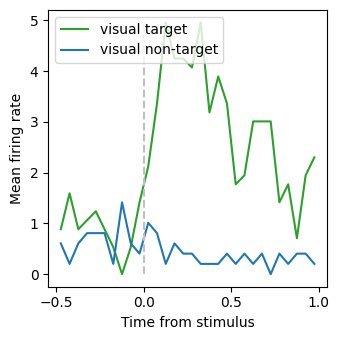

In [29]:
fig, ax = plt.subplots(figsize = (3.5, 3.5)) 
ax.plot(bin_centers, vis_target_psth, color = 'tab:green', label = 'visual target')
ax.plot(bin_centers, vis_nontarget_psth, color = 'tab:blue', label = 'visual non-target')
ax.plot([0, 0], [0, np.nanmax( vis_target_psth)], color = 'silver', ls = '--')
ax.set_xlabel('Time from stimulus')
ax.set_ylabel('Mean firing rate')
ax.legend(loc = 'upper left')
plt.tight_layout()